In [1]:
import netCDF4
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from osgeo import gdal,osr,ogr

In [3]:
import sys
sys.path.append('../../')

from tsgen import TsGenerator
from nc_explorer import NcExplorer

tsgen = TsGenerator()
exp = NcExplorer()

Declaring class instance from: S3-FRBR:Nc_Explorer
Input NetCDF file folde not set. Proceed at your own risk.
Declaring class instance from: S3-FRBR:Nc_Explorer
Input NetCDF file folde not set. Proceed at your own risk.


In [4]:
def nc_dt2num(date):
    # https://stackoverflow.com/questions/39997314/write-times-in-netcdf-file
    units = "hours since 1900-01-01 00:00:00.0"
    calendar = "gregorian"
    return netCDF4.date2num(date, units=units, calendar=calendar)

In [7]:
# set the data directories
shapefile = "D:\\A1_JM\\areas\\previous_areas\\manacapuru.shp"
ncs = "D:\\git-repos\\cams_visu\\cams_visu\\test_dl\\cams_2019.nc"

In [5]:
exp = NcExplorer(verbose=True)

Declaring class instance from: S3-FRBR:Nc_Explorer
Verbose set to True.
Input NetCDF file folde not set. Proceed at your own risk.


In [8]:
cams_nc = netCDF4.Dataset(ncs,'r')
cams_nc.dimensions

OrderedDict([('longitude',
              <class 'netCDF4._netCDF4.Dimension'>: name = 'longitude', size = 305),
             ('latitude',
              <class 'netCDF4._netCDF4.Dimension'>: name = 'latitude', size = 249),
             ('time',
              <class 'netCDF4._netCDF4.Dimension'> (unlimited): name = 'time', size = 1460)])

In [23]:
# get the longitude information
lons = cams_nc.variables['longitude'][:]
# get the latitude information
lats = cams_nc.variables['latitude'][:]
# extract the time dimension
time = cams_nc.variables['time'][:]

In [13]:
# Sentinel-3
madeiraxls = 'D:\\processing\\win\\MADEIRAv9b.xlsx'
df_s3 = pd.read_excel(madeiraxls,sheet_name='MADEIRAv9b')

# removes hour:minute:seconds from Sentinel-3 data.
df_s3['Date'] = [e.replace(hour=0, minute=0, second=0) for e in df_s3['Datetime']]

# Sort the data by increasing date
df_s3_srtd = df_s3.sort_values(by='Date')

# Get S3 data matching CAMS year 2019
s3_2019 = df_s3_srtd[df_s3_srtd['Date'].dt.year == 2019].copy()

# Create a new column with the same numeric date format as CAMS
s3_2019['dt2num'] = [int(nc_dt2num(d)) for d in s3_2019['Date']]

# Fix the index
s3_2019.reset_index(drop=True, inplace=True)

In [17]:
# Manacapuru Centroid
query_lon, query_lat = -60.8911, -3.5726

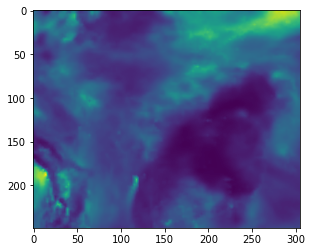

In [19]:
# get the total Aerosol Optical Depth at 865nm 
aod_band = cams_nc.variables['aod865'][120][:]
 
# show the AOD
plt.imshow(aod_band)
plt.show()

In [40]:
lon_grid, lat_grid = np.meshgrid(lons, lats)

In [53]:
exp.get_point_data_in_single_band(aod_band,
                                  lon=lon_grid,
                                  lat=lat_grid, 
                                  target_lon=query_lon,
                                  target_lat=query_lat)[1]

S3-FRBR:Nc_Explorer.get_point_data_in_single_band()



0.04124968892540304

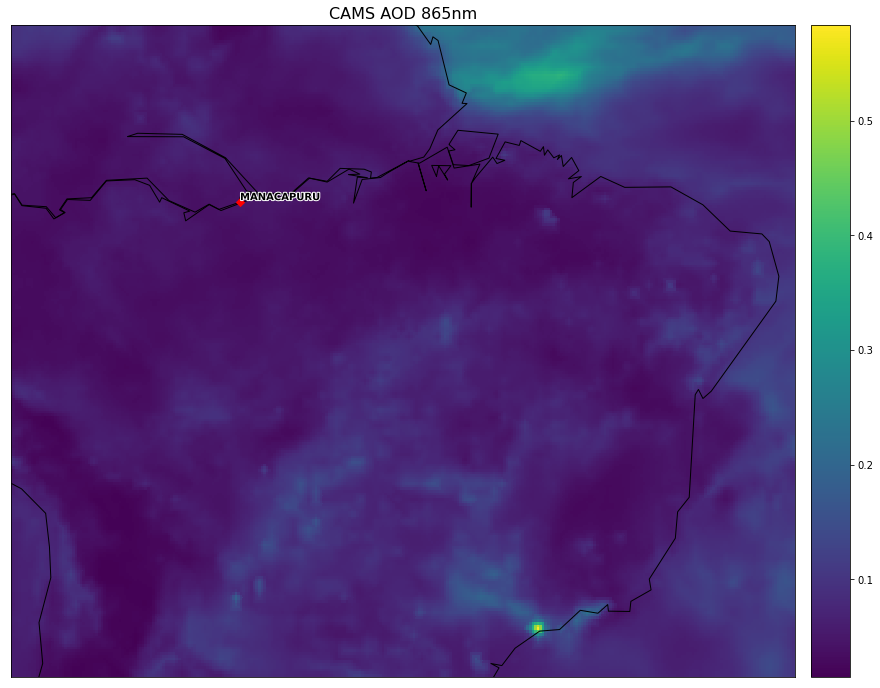

In [177]:
import matplotlib.patheffects as PathEffects
from mpl_toolkits.basemap import Basemap

# Make this plot larger.
plt.figure(figsize=(16,12))

plt.title(f'CAMS AOD 865nm', fontsize=16)

# Miller projection:
m = Basemap(projection='mill',
            lat_ts=10,
            llcrnrlon=lon_grid.min(),
            urcrnrlon=lon_grid.max(),
            llcrnrlat=lat_grid.min(),
            urcrnrlat=lat_grid.max(),
            resolution='c')

m.drawcoastlines()

x, y = m(lon_grid, lat_grid)
plot_var = aod_band
m.pcolormesh(x, y, plot_var, shading='flat') # cmap=plt.cm.gray
m.colorbar(location='right')


xpt, ypt = m(query_lon,query_lat)
m.plot(xpt, ypt, 'rD')
txt = plt.text(xpt, ypt, f'MANACAPURU',fontsize=10,fontweight='bold',
                ha='left',va='bottom',color='k')
txt.set_path_effects([PathEffects.withStroke(linewidth=2, foreground='w')])

plt.savefig('CAMS_manaca.png', bbox_inches='tight')
plt.show()

## Get AOD information over every CAMS day that match S3

In [61]:
ncs = "D:\\git-repos\\cams_visu\\cams_visu\\test_dl\\cams_2019.nc"
cams_nc = netCDF4.Dataset(ncs,'r')
# get the longitude information
lons = cams_nc.variables['longitude'][:]
# get the latitude information
lats = cams_nc.variables['latitude'][:]
# extract the time dimension
time = cams_nc.variables['time'][:]
# convert the 1D lon/lat arrays to 2D
lon_grid, lat_grid = np.meshgrid(lons, lats)

In [81]:
def get_cams_band_by_time(numeric_date, cams_time_array):
    pos = np.where(cams_time_array == numeric_date)[0]
    return pos[0]

In [82]:
# test
get_cams_band_by_time(1043856, time)

120

In [71]:
pos = get_cams_band_by_time(1043856, time)
aod_band = cams_nc.variables['aod865'][120][:]
cams_val = exp.get_point_data_in_single_band(aod_band, lon=lon_grid, lat=lat_grid,
                                             target_lon=query_lon, target_lat=query_lat)[1]
cams_val

S3-FRBR:Nc_Explorer.get_point_data_in_single_band()



0.04124968892540304

In [83]:
def find_cams_val(number_date, cams_time_array):
    # Manacapuru Centroid
    query_lon, query_lat = -60.8911, -3.5726
    # query for the corret day position inside the CAMS time array
    day_position = get_cams_band_by_time(number_date, cams_time_array)
    # extract CAMS AOD data at this day
    aod_band = cams_nc.variables['aod865'][day_position][:]
    # query the AOD pixel value over the target coordinates
    cams_val = exp.get_point_data_in_single_band(aod_band, 
                                                 lon=lon_grid, 
                                                 lat=lat_grid,
                                                 target_lon=query_lon,
                                                 target_lat=query_lat)[1]
    
    return cams_val

In [90]:
aod_values = []

for idx, row in s3_2019.iterrows():
    res = find_cams_val(row['dt2num'], time)
    aod_values.append(res)

s3_2019['cams_aod'] = aod_values

S3-FRBR:Nc_Explorer.get_point_data_in_single_band()

S3-FRBR:Nc_Explorer.get_point_data_in_single_band()

S3-FRBR:Nc_Explorer.get_point_data_in_single_band()

S3-FRBR:Nc_Explorer.get_point_data_in_single_band()

S3-FRBR:Nc_Explorer.get_point_data_in_single_band()

S3-FRBR:Nc_Explorer.get_point_data_in_single_band()

S3-FRBR:Nc_Explorer.get_point_data_in_single_band()

S3-FRBR:Nc_Explorer.get_point_data_in_single_band()

S3-FRBR:Nc_Explorer.get_point_data_in_single_band()

S3-FRBR:Nc_Explorer.get_point_data_in_single_band()

S3-FRBR:Nc_Explorer.get_point_data_in_single_band()

S3-FRBR:Nc_Explorer.get_point_data_in_single_band()

S3-FRBR:Nc_Explorer.get_point_data_in_single_band()

S3-FRBR:Nc_Explorer.get_point_data_in_single_band()

S3-FRBR:Nc_Explorer.get_point_data_in_single_band()

S3-FRBR:Nc_Explorer.get_point_data_in_single_band()

S3-FRBR:Nc_Explorer.get_point_data_in_single_band()

S3-FRBR:Nc_Explorer.get_point_data_in_single_band()

S3-FRBR:Nc_Explorer.get_point_data_in_single_b

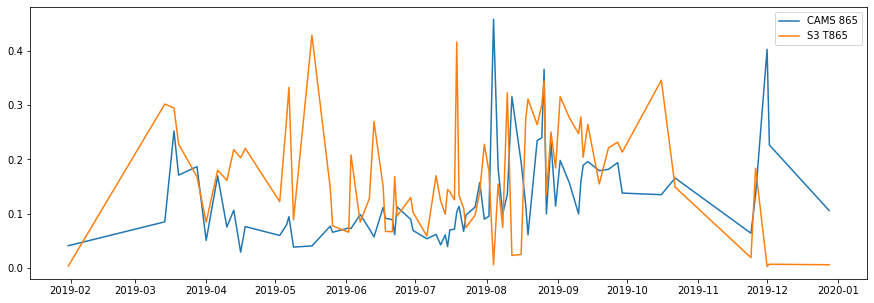

In [175]:
plt.rcParams['figure.figsize'] = [15, 5]
plt.plot(s3_2019['Date'],s3_2019['cams_aod'], label='CAMS 865')
plt.plot(s3_2019['Date'],s3_2019['T865'], label='S3 T865')
plt.legend()
plt.savefig('cams_vs_s3.png', bbox_inches='tight')

Text(0, 0.5, 'S3 AOD 865')

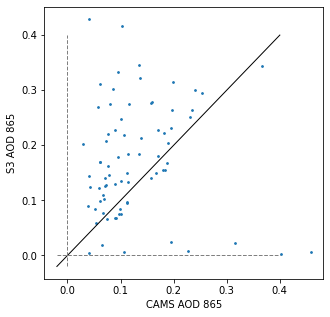

In [181]:
plt.rcParams['figure.figsize'] = [5, 5]
plt.scatter(s3_2019['cams_aod'], s3_2019['T865'], s=3)
plt.plot([-0.02, 0.4], [-0.02, 0.4], 'k-', linewidth=1)
plt.plot([0, 0], [-0.02, 0.4], c='grey', linestyle='dashed', linewidth=1)
plt.plot([-0.02, 0.4], [0, 0], c='grey', linestyle='dashed', linewidth=1)
plt.xlabel('CAMS AOD 865')
plt.ylabel('S3 AOD 865')

In [107]:
s3_2019['cams_aod'].corr(s3_2019['T865'])

0.011755028588951048

## Loop through CAMS valid dates

In [109]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.animation import PillowWriter 

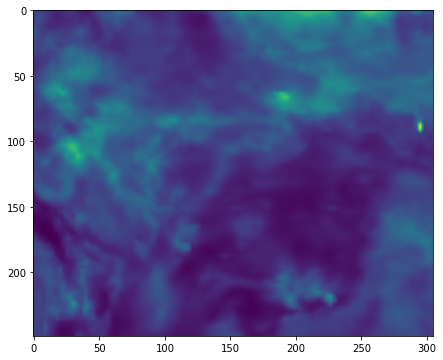

In [136]:
# create a list of images
plt.rcParams['figure.figsize'] = [8, 6]
fig = plt.figure()
ims = []
var_time = cams_nc.variables['time']

for idx, row in s3_2019.iterrows():
    readable_date = str(netCDF4.num2date(row['dt2num'], var_time.units, var_time.calendar))
    day_position = get_cams_band_by_time(row['dt2num'], time)
    aod_band = cams_nc.variables['aod865'][day_position][:]
    frame = plt.imshow(aod_band)
#     im.set_xlabel(readable_date)
    ims.append([frame])


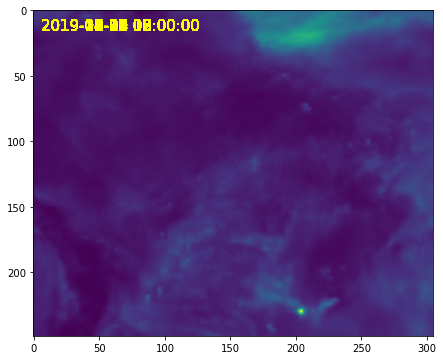

In [173]:
# create a list with all CAMS dates
plt.rcParams['figure.figsize'] = [8, 6]

ims = []
fig = plt.figure("Animation")
ax = fig.add_subplot(111)
var_time = cams_nc.variables['time']
time = cams_nc.variables['time'][:]

for i in range(0,len(time)):
    readable_date = str(netCDF4.num2date(time[i], var_time.units, var_time.calendar))
    aod_band = cams_nc.variables['aod865'][i][:]
    frame = ax.imshow(aod_band)
    t = ax.text(5,15,readable_date,color='yellow',fontsize=15) # add text
    ims.append([frame,t])


In [174]:
class LoopingPillowWriter(PillowWriter):
    def finish(self):
        self._frames[0].save(
            self._outfile, save_all=True, append_images=self._frames[1:],
            duration=int(1000 / self.fps), loop=0)

    
ani = animation.ArtistAnimation(fig, ims, interval=50, blit=True, repeat_delay=500)

writer = PillowWriter(fps=11)
# ani.save("demo2.gif", writer=writer)
ani.save('full_cams.gif', writer=LoopingPillowWriter(fps=11)) 

plt.show()

## CAMS as a Proxy

In [1]:
# win
# subset = 'D:\\S3\\L2_WFR_subset\\MANACAPURU\\S3A_OL_2_WFR____20191104T135002_20191104T135302_20191124T134508_0179_051_124_3060_MAR_O_NT_002_subset.txt'
# unix
subset = '/d_drive_data/S3/L2_WFR_subset/MANACAPURU/S3A_OL_2_WFR____20191104T135002_20191104T135302_20191124T134508_0179_051_124_3060_MAR_O_NT_002_subset.txt'